In [2]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import datetime as dt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree

from sklearn.model_selection import train_test_split

In [3]:
!pip install scikit-optimize

     |████████████████████████████████| 102kB 4.3MB/s 


In [4]:
# url_train = 'https://raw.githubusercontent.com/SantiagoTadini/TP2-Datos/main/Features/data_train.csv'
# url_test = 'https://raw.githubusercontent.com/SantiagoTadini/TP2-Datos/main/Features/data_test.csv'
# url_test_kaggle = 'https://raw.githubusercontent.com/SantiagoTadini/TP2-Datos/main/Features/data_test_kaggle.csv'

url_train = 'https://raw.githubusercontent.com/fedelececilia/TP2_Org_de_Datos/main/data_train_para_rf.csv'
url_test = 'https://raw.githubusercontent.com/fedelececilia/TP2_Org_de_Datos/main/data_test_para_rf.csv'
url_test_kaggle = 'https://raw.githubusercontent.com/fedelececilia/TP2_Org_de_Datos/main/data_test_kaggle_para_rf.csv'

data_train = pd.read_csv(url_train)
data_test = pd.read_csv(url_test)
data_test_kaggle = pd.read_csv(url_test_kaggle)

In [5]:
# Verificamos que todos los valores de los 3 set de datos sean NO nulos (la suma debe dar 0)
data_train.isnull().sum().sum() + data_test.isnull().sum().sum() + data_test_kaggle.isnull().sum().sum()

0

In [6]:
# Separamos los set de datos (data_train y data_test) de sus columnas 'Target'
# 'x' son los datos, 'y' es el target:
#   --> x_train son los datos con los que entrenar
#   --> y_train son las soluciones con las que comparar lo entrenado con x_train
#   --> x_test son los datos con los que probar
#   --> y_test son las soluciones con las que comparar lo probado con x_test
x_train = data_train.iloc[:, :-1]
y_train = data_train.iloc[:, -1]
x_test = data_test.iloc[:, :-1]
y_test = data_test.iloc[:, -1]

Optimización de hiperparámetros

In [ ]:
# HYPEROPT:
# fmin: class which will host optimization process
# tpe: the optimizer to be used (Tree of Parzen Estimator)
# hp: for defining the search space
from hyperopt import STATUS_OK
from hyperopt import fmin, tpe, hp
from hyperopt.pyll.base import scope 

def objective(x):
  model = RandomForestRegressor(n_estimators=x['n_estimators'], max_depth=x['max_depth'], max_features=x['max_features'], min_samples_split=x['min_samples_split'], min_samples_leaf=x['min_samples_leaf'], max_leaf_nodes=x['max_leaf_nodes']).fit(x_train, y_train)
  logloss = log_loss(y_test, model.predict(x_test))
  # print(logloss)
  return {
    'loss': logloss,
    'status': STATUS_OK
  }

# Search space definition
# space = hp.uniform('x', -2, 2)
space = {'n_estimators' : scope.int(hp.uniform('n_estimators',1,70)),
         'max_depth' : scope.int(hp.uniform('max_depth',500,1700)),
         'max_features' : scope.int(hp.uniform('max_features',1,30)),
         'min_samples_split' : scope.int(hp.uniform('min_samples_split',20,300)),
         'min_samples_leaf' : scope.int(hp.uniform('min_samples_leaf',1,50)),
         'max_leaf_nodes' : scope.int(hp.uniform('max_leaf_nodes',2,500))
        }

# Init the optimizer
# fn: function to be optimized
# space: search space
# algo: optimizer algorithm
# max_evals: number of iterations
best = fmin(
    fn=objective,  
    space=space,
    algo=tpe.suggest,
    max_evals=500
)

print(f"Optimal value of x: {best}")

100%|██████████| 500/500 [11:02<00:00,  1.33s/it, best loss: 0.4492439448770249]
Optimal value of x: {'max_depth': 1092.7822807082073, 'max_features': 7.387604442981293, 'max_leaf_nodes': 161.05669329457137, 'min_samples_leaf': 11.809329958778918, 'min_samples_split': 20.601684117685537, 'n_estimators': 17.24899317723877}


In [60]:
# 'max_depth': 659.1085772267065, 'max_features': 2.6200853809833173, 'max_leaf_nodes': 95.71226697621607, 'min_samples_leaf': 11.593417077500536,
#  'min_samples_split': 57.01324088673158, 'n_estimators': 4.161772427116747 --> 0.54140 en Kaggle (csv sin ruido ni smoothing, con iterative imputer)

modelo_optimizado = RandomForestRegressor(random_state=1, n_estimators=5, min_samples_split=58, max_features=3, max_depth=16, max_leaf_nodes=96, min_samples_leaf=12)
modelo_optimizado.fit(x_train, y_train)
preds_optimizado = modelo_optimizado.predict(x_test)

In [61]:
# ERROR DE TRAIN DEL MODELO OPTIMIZADO
log_loss(y_train, modelo_optimizado.predict(x_train))

0.28231258295457906

In [62]:
# ERROR DE TEST DEL MODELO OPTIMIZADO
log_loss(y_test, preds_optimizado)

0.4721267965048252

In [63]:
# Sacamos el preds_test_agrupado_por_opp
oportunidades_test = data_test['Opportunity_ID']
oportunidades_test = oportunidades_test.to_frame()

oportunidades_test['Target'] = preds_optimizado

preds_test_optimizado_agrupado_por_opp = oportunidades_test.groupby('Opportunity_ID').agg({'Target' : 'max'})
preds_test_optimizado_agrupado_por_opp = preds_test_optimizado_agrupado_por_opp.reset_index()

In [64]:
# Sacamos el y_test_agrupado_por_opp
oportunidades_test['Target'] = y_test

y_test_agrupado_por_opp = oportunidades_test.groupby('Opportunity_ID').agg({'Target' : 'max'})
y_test_agrupado_por_opp = y_test_agrupado_por_opp.reset_index()
y_test_agrupado_por_opp = y_test_agrupado_por_opp['Target']

In [65]:
# ERROR DE TEST DEL MODELO OPTIMIZADO AGRUPADO
log_loss(y_test_agrupado_por_opp, preds_test_optimizado_agrupado_por_opp)

0.694444926576771

Gráficos

In [66]:
modelo_optimizado.feature_importances_

array([0.01498136, 0.00730535, 0.0071716 , 0.00169494, 0.01884304,
       0.03232755, 0.0011437 , 0.03299718, 0.02124935, 0.00094141,
       0.00526959, 0.13834626, 0.00732177, 0.00709441, 0.05559232,
       0.03002364, 0.00309153, 0.        , 0.01269748, 0.03998728,
       0.00437298, 0.00213639, 0.        , 0.01493243, 0.01405722,
       0.00023777, 0.04940136, 0.00768345, 0.03270534, 0.01901375,
       0.06617134, 0.02136803, 0.03008148, 0.03314404, 0.00979166,
       0.01286375, 0.00281408, 0.0021909 , 0.00460723, 0.10290331,
       0.00374048, 0.05319218, 0.03568487, 0.02036805, 0.01845814])

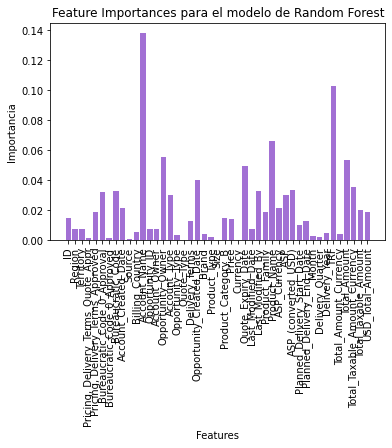

In [101]:
a = plt.bar(x_train.columns, modelo_optimizado.feature_importances_, color='#A270D4')
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Feature Importances para el modelo de Random Forest')
plt.xticks(rotation='vertical')
plt.show()

In [68]:
# Son 5 los estimadores
modelo_optimizado.estimators_

[DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=16,
                       max_features=3, max_leaf_nodes=96,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=12, min_samples_split=58,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1791095845, splitter='best'),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=16,
                       max_features=3, max_leaf_nodes=96,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=12, min_samples_split=58,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2135392491, splitter='best'),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=16,
                       max_features=3, max_leaf_nodes=96,
                       min_impurity_decrease=0.0, min_i

In [80]:
tree0 = modelo_optimizado.estimators_[0]
tree1 = modelo_optimizado.estimators_[1]
tree2 = modelo_optimizado.estimators_[2]
tree3 = modelo_optimizado.estimators_[3]
tree4 = modelo_optimizado.estimators_[4]

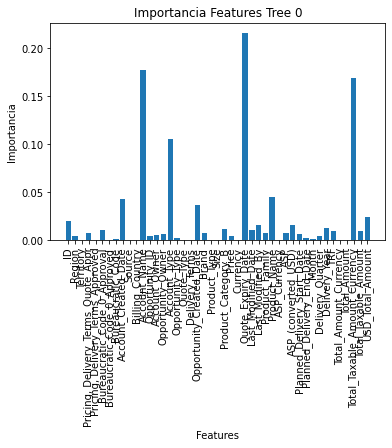

In [31]:
# Importancia de los features para el estimador tree0
plt.bar(x_train.columns, tree0.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features Tree 0')
plt.xticks(rotation='vertical')
plt.show()

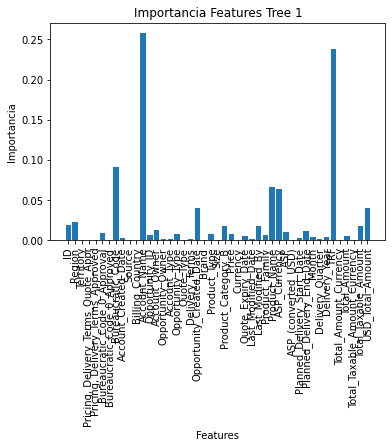

In [81]:
# Importancia de los features para el estimador tree1
plt.bar(x_train.columns, tree1.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features Tree 1')
plt.xticks(rotation='vertical')
plt.show()

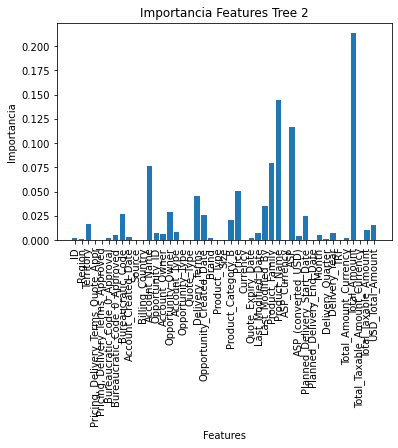

In [83]:
# Importancia de los features para el estimador tree2
plt.bar(x_train.columns, tree2.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features Tree 2')
plt.xticks(rotation='vertical')
plt.show()

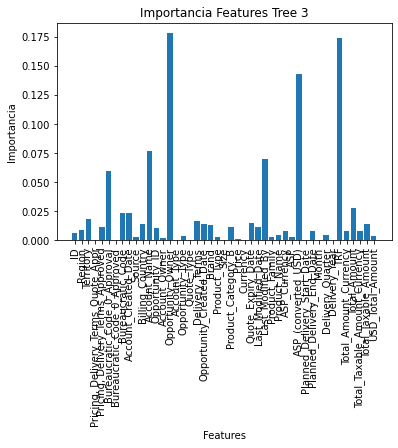

In [84]:
# Importancia de los features para el estimador tree3
plt.bar(x_train.columns, tree3.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features Tree 3')
plt.xticks(rotation='vertical')
plt.show()

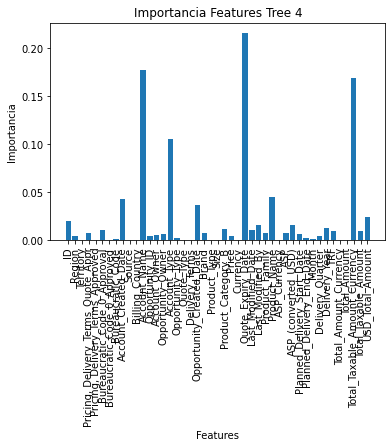

In [85]:
# Importancia de los features para el estimador tree4
plt.bar(x_train.columns, tree4.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features Tree 4')
plt.xticks(rotation='vertical')
plt.show()

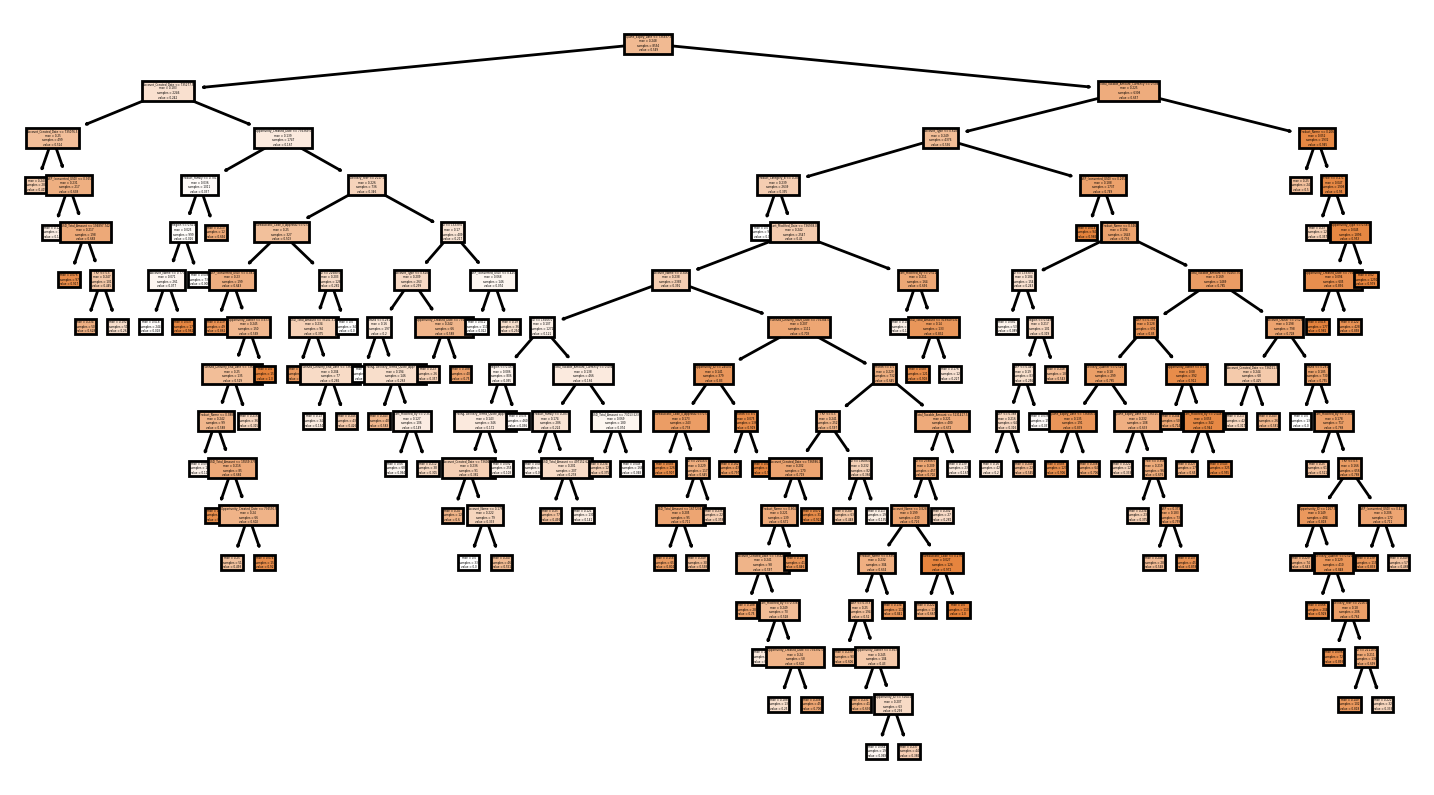

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9,5), dpi=200)
tree.plot_tree(tree4,\
               feature_names = x_train.columns,\
               filled=True);

Ahora predecimos con el set de test_kaggle

In [ ]:
# Ahora predecimos con el set de test
preds_test_kaggle_optimizado = modelo_optimizado.predict(data_test_kaggle)

In [ ]:
# Sacamos el preds_test_agrupado_por_opp
oportunidades_test = data_test_kaggle['Opportunity_ID']
oportunidades_test = oportunidades_test.to_frame()

oportunidades_test['Target'] = preds_test_kaggle_optimizado

preds_test_kaggle_optimizado_agrupado_por_opp = oportunidades_test.groupby('Opportunity_ID').agg({'Target' : 'max'})
preds_test_kaggle_optimizado_agrupado_por_opp = preds_test_kaggle_optimizado_agrupado_por_opp.reset_index()

In [ ]:
preds_test_kaggle_optimizado_agrupado_por_opp['Opportunity_ID'] = preds_test_kaggle_optimizado_agrupado_por_opp['Opportunity_ID'].astype(int)

Agregamos todo a un archivo .csv

In [ ]:
from google.colab import files
preds_test_kaggle_optimizado_agrupado_por_opp.to_csv('preds_test.csv', index=False, header=True)
files.download('preds_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>